<font size="5">Time Series De-Noising</font><br>
<br>
Some time series might contain very noisy data, for example stock markets, sensors, images.<br>
It might skew your data and carry not usefull information.<br>
Machine learning models might pickup on it and overfit during training or learn patterns in noise, that are not relevant.<br>
For this problem it might be usefull to use denoising algorithms. There are many solutions, but I will present a deep learning<br>
approach, that might be directly implemented to the model as preprocessing layer and be a part of one consistent model.<br>
For this short presentation I will use BA (Boeing) corp. stock data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras.regularizers import l1_l2
from tensorflow.keras import mixed_precision
import warnings
warnings.filterwarnings('ignore')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('float32')

In [2]:
# defining the function which plots candlestick bars
def plot_candles(o, c, h, l, figsize = (10,5)):
    up = np.zeros(len(o))
    up[(c - o) >= 0] = 1
    up = up.astype(bool)

    down = np.zeros(len(o))
    down[(c - o) < 0] = 1
    down = down.astype(bool)

    index = np.arange(1,len(o)+1)
    
    fig, ax = plt.subplots(1,1,figsize = figsize)
    ax.bar(index, h - l, bottom=l, width=0.1, color = 'Black')
    ax.bar(index[up], c[up] - o[up], bottom=o[up], width=0.4, color = 'Green')
    ax.bar(index[down], o[down] -c[down], bottom=c[down], width=0.4, color = 'Red')

# defining function that automatically generates network of dense layers
def enc_dec(input_layer, activation, kernel_regularizer):
    layer = Dense(16, activation = activation)(input_layer)
    layer = Dense(12, activation = activation, kernel_regularizer=kernel_regularizer)(layer)
    layer = Dense(8, activation = activation, kernel_regularizer=kernel_regularizer)(layer)
    layer = Dense(12, activation = activation, kernel_regularizer=kernel_regularizer)(layer)
    layer = Dense(16, activation = activation, kernel_regularizer=kernel_regularizer)(layer)
    output = Dense(input_layer.shape[1])(layer)
    return output

In [3]:
activation = 'leaky_relu' # defining activation function
kernel_regularizer = l1_l2(l1=0.002, l2=0.002) # defining regularization

period = 100 # defining length of time series to be denoised

main_input = Input((period,)) # defining input
output = enc_dec(main_input,activation, kernel_regularizer) # calling function to build network

#defining learning rate for Adam optimizer
tf.keras.optimizers.Adam(
    learning_rate=0.02,
    name='Adam'
)

# creating model
model = tf.keras.models.Model(inputs=main_input, outputs=output)
# compiling to use Adam optimizer, 'mse' loss and 'mae' for accuracy
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

Now as we have defined our model, we need to load and prepare our data

In [4]:
data = joblib.load('BA_2020-03-29_2024-08-04.sav') # loading data
data['datetime'] = data['datetime'].apply(pd.to_datetime) # setting column to datetime format for future use
data.set_index('datetime', inplace=True) # setting datetime column to be index
#resampling data to 1 day periods as the original data is 1 min
data = data.resample('1d').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last'}).dropna() 

# creating training examples
training = data['close'].copy()
for i in range(1,period):
    training = pd.concat([training, data['close'].shift(-i)], axis = 1)
training = training.dropna().values
# target is the same as training data as we input period and want to get the same data only denoised

Now as we have our data and model, we can start training

In [5]:
model.fit(training, training, validation_split=0.2, validation_freq=50, batch_size = 4000, epochs = 6000)

Epoch 1/6000
1/1 [==============================] - 2s 2s/step - loss: 40181.2656 - mae: 195.5382
Epoch 2/6000
1/1 [==============================] - 0s 5ms/step - loss: 39583.7695 - mae: 194.6851
Epoch 3/6000
1/1 [==============================] - 0s 5ms/step - loss: 39189.4805 - mae: 194.0904
Epoch 4/6000
1/1 [==============================] - 0s 4ms/step - loss: 38965.6758 - mae: 193.7650
Epoch 5/6000
1/1 [==============================] - 0s 4ms/step - loss: 38806.6719 - mae: 193.5245
Epoch 6/6000
1/1 [==============================] - 0s 4ms/step - loss: 38647.6602 - mae: 193.2394
Epoch 7/6000
1/1 [==============================] - 0s 3ms/step - loss: 38518.3242 - mae: 192.9547
Epoch 8/6000
1/1 [==============================] - 0s 5ms/step - loss: 38391.6719 - mae: 192.6135
Epoch 9/6000
1/1 [==============================] - 0s 4ms/step - loss: 38231.3984 - mae: 192.1512
Epoch 10/6000
1/1 [==============================] - 0s 4ms/step - loss: 38033.0039 - mae: 191.5616
Epoch 11/6

That's great! Our validation data is even more accurate than training.<br>
That is because our data is not shuffled and validation is 20% from our time series end.<br>
It just means that validation data is less noisy.<br>
Now lets visually inspect our results

32/32 [==============================] - 0s 825us/step


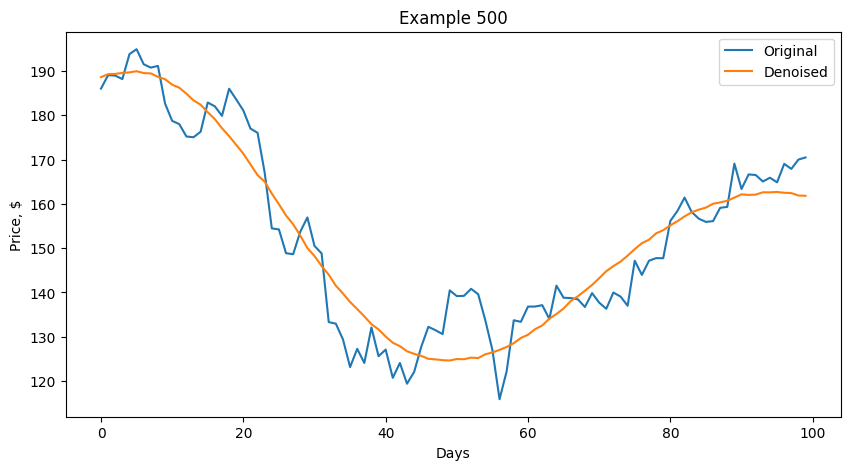

In [6]:
# getting the results
prediction = model.predict(training)

example = 500 #set which example we want to see

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.set_title(f'Example {example}')
ax.plot(training[example], label = 'Original')
ax.plot(prediction[example], label = 'Denoised')
ax.set_xlabel('Days')
ax.set_ylabel('Price, $')
ax.legend()

Lets see how model works on validation

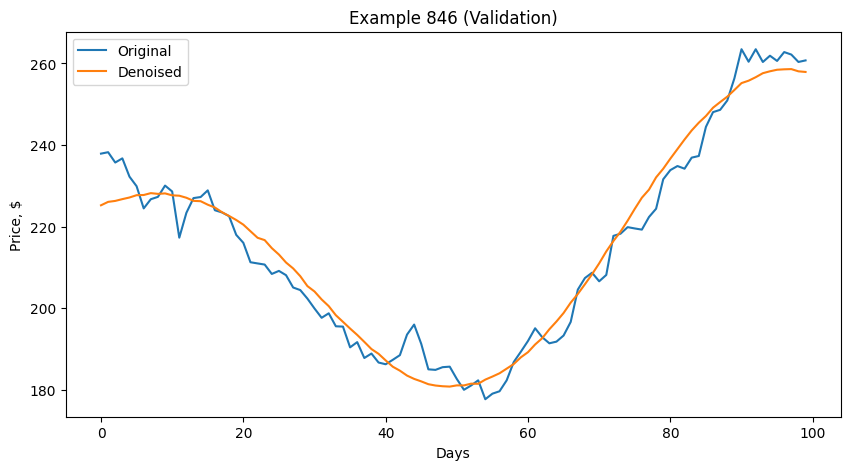

In [7]:
example = int(len(training)*0.8 + 50)

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.set_title(f'Example {example} (Validation)')
ax.plot(training[example], label = 'Original')
ax.plot(prediction[example], label = 'Denoised')
ax.set_xlabel('Days')
ax.set_ylabel('Price, $')
ax.legend()

Now lets see the candlesticks and denoised high, low, open and close lines

1/1 [==============================] - 0s 13ms/step


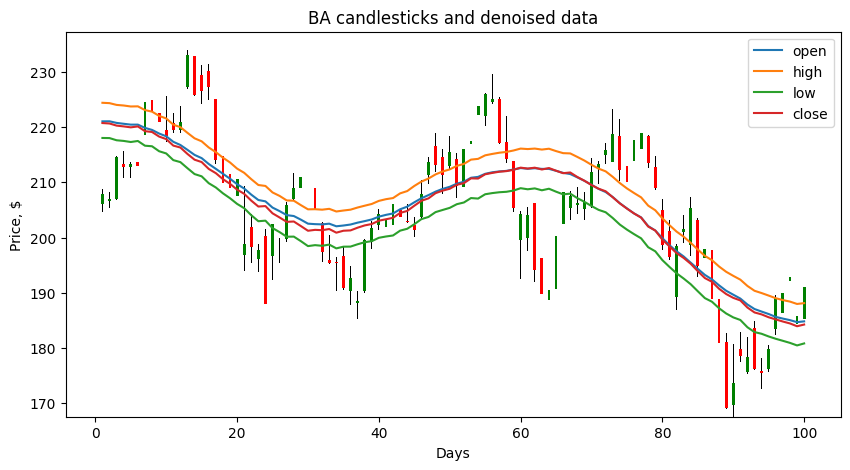

In [8]:
data_slice = data.iloc[400:500] # select slice from data, MUST BE OF LENGTH - 100
data_slice_denoised = data_slice.copy()
#iterating through model to denoise data
for i in data.columns:
    data_slice_denoised[i] = model.predict(data_slice[i].values[np.newaxis,:]).flatten()


plot_candles(data_slice['open'], data_slice['close'], data_slice['high'], data_slice['low'], figsize=(10,5))
plt.plot(np.arange(1,len(data_slice)+1, 1), data_slice_denoised, label = ['open', 'high', 'low','close'])
plt.title('BA candlesticks and denoised data')
plt.xlabel('Days')
plt.ylabel('Price, $')
plt.legend()

So, we have succesfully built a denoising network. The main advantage building it with neural networks<br>
is that now we can connect it directly to tensorflow graph and it can run together with your model<br>
as a single solution on GPU or TPU.